[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Redes_Neuronales_Scratch/blob/main/semana3/ClaseRed_Backpropagation.ipynb)

De clase anterior

In [ ]:
mat = np.array([[1,100],[2,150],[1,400]])
mat

array([[  1, 100],
       [  2, 150],
       [  1, 400]])

In [ ]:
min = mat.min(axis=0, keepdims=True)
max = mat.max(axis=0, keepdims=True)

In [ ]:
(mat - min)/(max - min)

array([[0.        , 0.        ],
       [1.        , 0.16666667],
       [0.        , 1.        ]])

# Red Neuronal

En esta sesión instanciaremos un objeto de clase red neuronal (que nosotros crearemos). Veremos como funciona el feedforward (no tan complicado dada la clase pasada) y despues veremos backpropagation (un poco menos fácil, es una generalización de la red que se entreno la semana 2, la que constaba de una sola capa).

Se utilizará la funcion de perdida de Error Cuadrático Medio, así como funciones de activación distintas (podrá ser ReLu, Sigmoide y Lineal)



In [ ]:
import numpy as np

In [ ]:
# Proceso que se utiliza para convertir características categóricas en características binarias
def one_hot_encode(y, num_classes):
    y_one_hot = np.zeros((y.shape[0], num_classes))
    idx = [np.arange(y.shape[0]), y]
    y_one_hot[idx] = 1
    return y_one_hot

Ejemplificando "One Hot Encoding" (ayuda en problemas de clasificación)

In [ ]:
# Crea nuevas columnas en la que me dice si el elemento pertenece a la categoría 0, a la 1 o a la 2
encoded = one_hot_encode(np.array([1, 0, 2, 1]), 3)
encoded

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Función de perdida

In [ ]:
# Nuestra función de perdida (Error cuadrátio medio)
def mse(y_hat, y):
    return np.mean((y - y_hat)**2)

# Dado su nombre y forma, ¿quien es esta función?
def d_mse(y_hat, y):
    return (1 / y_hat.shape[0]) * (1/y_hat.shape[-1]) * -2 * np.sum(y - y_hat, axis=0)

In [ ]:
uno = np.array([1,2,3,4,5])
dos = np.array([1,2,3,4,7])
mse(uno, dos)

0.8

In [ ]:
compare_to_encoded = np.array([[1., 0., 0.],
                              [1., 0., 0.],
                              [0., 0., 1.],
                              [0., 1., 0.]])

In [ ]:
mse(encoded, compare_to_encoded)

0.16666666666666666

Funciones de activación

In [ ]:
def linear(x):
    return x


def d_linear(x):
    return np.ones_like(x)


def relu(x):
    return np.where(x > 0, x, 0)


def d_relu(x):
    return np.where(x > 0, 1, 0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

¿Que funciones de activación no están aquí?

# Creación de la clase Red Neuronal

Atributos que tendrá nuestro objeto:

- Pesos
- Sesgos
- Tape *
- Función de activación
- Derivadas de las activaciones

Métodos que tendrá:

- __ init __
- forward
- backward
- predict

In [ ]:
input_size = 3
hidden_sizes = [3,4]
output_size = 1

In [ ]:
# Creación de nuestra clase red, con metodos "forward" para avanzar sobre nuestra red, "backward" para optimizar parámetros, "predict" para lo obvio
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i + 1]
            self.weights.append(np.random.randn(n_in, n_out))
            self.biases.append(np.random.randn(1, n_out))

        self.tape = [None for _ in range(len(self.weights) + 1)]
        self.activations = [linear] + [relu for _ in range(len(self.weights) - 1)] + [sigmoid]
        self.d_activations = [d_linear] + [d_relu for _ in range(len(self.weights) - 1)] + [d_sigmoid]

    def forward(self, x, grad=False):
        if grad and self.tape[0] is not None:
            raise ValueError("Cannot call forward with grad without calling backwards")

        if grad:
            self.tape[0] = x
        
        for i in range(len(self.weights)):
            x_hat = x @ self.weights[i] + self.biases[i]
            x = self.activations[i + 1](x_hat)
            if grad:
                self.tape[i + 1] = x_hat

        return x

    def backward(self, d_loss):
        assert d_loss.shape == self.weights[-1].shape[-1:]

        weights_grad = [None for w in self.weights]
        biases_grad = [None for b in self.biases]

        d_activation = self.d_activations[-1]
        error = d_loss * d_activation(self.tape[-1]) # (n_out) * (n_out)
        error = error.reshape(1, -1)

        for i in reversed(range(len(self.weights))):
            # error = (1, n_out)
            # tape[i] = (n_in)
            # weights[i] = (n_in, n_out)
            x = self.tape[i]
            activation = self.activations[i]
            d_activation = self.d_activations[i]

            weights_grad[i] = error * activation(x.reshape(-1, 1)) # (1, n_out) * (n_in, 1) -> (n_in, n_out) * (n_in, n_out) por broadcast -> (n_in, n_out)
            biases_grad[i] = error * 1 # derivada de los sesgos es un vector de unos, lo representamos explicitamente como 1 (uso de broadcasting)
            
            error = error @ self.weights[i].T  # (1, n_out) @ (n_out, n_in) -> (1, n_in)
            error = error * d_activation(x).reshape(1, -1) # (1, n_in) * (1, n_in)


        self.tape = [None for _ in range(len(self.weights) + 1)]

        return weights_grad, biases_grad

    def predict(self, x):
        y = self.forward(x)
        preds = np.argmax(y, axis=1) # Funciona para algoritmos de clasificación
        return preds # la salida sería "y"

# Revisando que la PreAlimentación (Feed Forward) funcione correctamente

In [ ]:
# Utilizaremos "assert", el cual regresa un aviso si la condición no se cumple
assert 1 == 2

In [ ]:
# Revisión
model = NeuralNetwork(2, [4], 1)

inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

targets = np.array([0, 1, 2, 1]).reshape(-1,1)

loss = (targets - sigmoid(relu(inputs @ model.weights[0] + model.biases[0]) @ model.weights[1] + model.biases[1]))**2   ## CASO 1 sola intermedia
assert np.allclose(loss.mean(), mse(model.forward(inputs), targets))

In [ ]:
mse(model.forward(inputs), targets)

1.4589297893031237

# Ejercicio: 

- ¿Que pasa en el código anterior si doy como capas intermedias la lista [3,4]? ¿Como evitar ese assertion error?

In [ ]:
# SOLUCION EJERCICIO
model = NeuralNetwork(2, [3,4], 1)

inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

targets = np.array([0, 1, 2, 1]).reshape(-1,1)

#loss = (targets - sigmoid(relu(inputs @ model.weights[0] + model.biases[0]) @ model.weights[1] + model.biases[1]))**2   ## CASO 1 sola intermedia
loss = (targets - sigmoid( relu(  relu(inputs @ model.weights[0] + model.biases[0]) @ model.weights[1] + model.biases[1]) @ model.weights[2] + model.biases[2]  )  )**2

assert np.allclose(loss.mean(), mse(model.forward(inputs), targets))

# Veamos los atributos de nuestro objeto "model"

In [ ]:
model.weights

[array([[ 0.24073852,  0.20096091,  0.92911829],
        [-0.63712995,  1.09077989, -1.62482104]]),
 array([[ 1.36350212,  0.97488742,  0.69743973,  0.1271166 ],
        [-1.6673961 , -0.09231721,  1.51636854,  0.10543813],
        [ 0.81293075,  0.92500843,  1.64515543, -1.04836395]]),
 array([[ 0.14528155],
        [-0.20414633],
        [ 0.91368903],
        [-0.04489293]])]

In [ ]:
model.biases

[array([[-0.50537507, -0.34782478, -0.40468396]]),
 array([[0.73586326, 0.27792488, 1.08513361, 1.08959538]]),
 array([[-0.201423]])]

In [ ]:
model.activations

[<function __main__.linear>,
 <function __main__.relu>,
 <function __main__.relu>,
 <function __main__.sigmoid>]

In [ ]:
model.d_activations

[<function __main__.d_linear>,
 <function __main__.d_relu>,
 <function __main__.d_relu>,
 <function __main__.d_sigmoid>]

In [ ]:
model.tape

[None, None, None, None]

# Analytical Gradient

In [ ]:
def compute_analytical_gradient(model, X, Y, batch_size, num_classes):
    analytical_weights_grad = [np.zeros(w.shape) for w in model.weights]
    analytical_biases_grad = [np.zeros(b.shape) for b in model.biases]

    batches = list(zip(X, Y))
    for i in range(0, len(batches), batch_size):
        batch = batches[i : i + batch_size]
        x, y = zip(*batch)
        x = np.array(x)
        y = np.array(y)
        y_one_hot = one_hot_encode(y, num_classes) # y   # cuando no sea problema de clasificación
        y_hat = model.forward(x, grad=True)

        weights_grad, biases_grad = model.backward(d_mse(y_hat, y_one_hot))
        for l in range(len(model.weights)):
            analytical_weights_grad[l] += weights_grad[l]
            analytical_biases_grad[l] += biases_grad[l]

    for l in range(len(model.weights)):
        analytical_weights_grad[l] /= len(X)
        analytical_biases_grad[l] /= len(X)

    return analytical_weights_grad, analytical_biases_grad

¿Puede ser que la derivada analítica de mis funciones no exista?

In [ ]:
# No ES NECESARIA
def compute_numerical_gradient(model, X, Y, batch_size, num_classes, delta=1e-8):
    batches = list(zip(X, Y))

    def compute_loss():
        loss = 0
        for i in range(0, len(batches), batch_size):
            batch = batches[i : i + batch_size]
            x, y = zip(*batch)
            x = np.array(x)
            y = np.array(y)
            y_one_hot = one_hot_encode(y, num_classes)
            y_hat = model.forward(x)
            loss += mse(y_hat, y_one_hot) * len(x)
        return loss / len(X)

    base_loss = compute_loss()

    numerical_weights_grad = [np.zeros(w.shape) for w in model.weights]
    numerical_biases_grad = [np.zeros(b.shape) for b in model.biases]
    for l in range(len(model.weights)):
        for ix, iy in np.ndindex(model.weights[l].shape):
            old_w = model.weights[l][ix][iy]
            new_w = old_w + delta
            model.weights[l][ix][iy] = new_w

            new_loss = compute_loss()
            dL = base_loss - new_loss
            dw = old_w - new_w
            numerical_weights_grad[l][ix][iy] = dL / dw

            model.weights[l][ix][iy] = old_w

        for ii in range(len(model.biases[l][0])):
            old_b = model.biases[l][0][ii]
            new_b = old_b + delta
            model.biases[l][0][ii] = new_b

            new_loss = compute_loss()
            dL = base_loss - new_loss
            db = old_b - new_b
            numerical_biases_grad[l][0][ii] = dL / db

            model.biases[l][0][ii] = old_b

    return numerical_weights_grad, numerical_biases_grad

# Revision de algoritmo de BackPropagation

In [ ]:
input_size = 2
hidden_sizes = [4]
output_size = 1
model = NeuralNetwork(input_size, hidden_sizes, output_size)

n_examples = 1000
n_classes = 1
x = np.random.randn(n_examples, input_size)
y = np.random.randint(0, n_classes, size=(n_examples, n_classes))

numerical_weights_grad, numerical_biases_grad = compute_numerical_gradient(
    model, x, y, batch_size=1, num_classes=n_classes
)
analytical_weights_grad, analytical_biases_grad = compute_analytical_gradient(
    model, x, y, batch_size=1, num_classes=n_classes
)

# check numerical and analytical gradients have same shape
assert len(numerical_weights_grad) == len(analytical_weights_grad) == len(analytical_biases_grad) == len(numerical_biases_grad)
for i in range(len(numerical_weights_grad)):
    assert numerical_weights_grad[i].shape == analytical_weights_grad[i].shape
    assert numerical_biases_grad[i].shape == analytical_biases_grad[i].shape


for l in range(len(model.weights)):
    with np.printoptions(precision=4, suppress=True):
        print(f"---- layer {l} ----")
        print("numerical weights gradient:\n", numerical_weights_grad[l])
        print("analytical weights gradient:\n", analytical_weights_grad[l])
        print()
        print("numerical biases gradient:\n", numerical_biases_grad[l])
        print("analytical biases gradient:\n", analytical_biases_grad[l])
        print()

        if not np.allclose(analytical_weights_grad[l], numerical_weights_grad[l], atol=1e-6):
            print(f"---- layer {l} ----")
            print("numerical weights gradient:\n", numerical_weights_grad[l])
            print("analytical weights gradient:\n", analytical_weights_grad[l])
            raise ValueError("incorrect backprop")

        if not np.allclose(analytical_biases_grad[l], numerical_biases_grad[l], atol=1e-6):
            print(f"---- layer {l} ----")
            print("numerical biases gradient:\n", numerical_biases_grad[l])
            print("analytical biases gradient:\n", analytical_biases_grad[l])
            raise ValueError("incorrect backprop")


In [ ]:
# with np.printoptions(precision=4, suppress=True):
#     print(analytical_biases_grad[1] / numerical_biases_grad[1])
#     print()
#     print(analytical_weights_grad[1] / numerical_weights_grad[1])

# Datos

In [ ]:
import matplotlib.pyplot as plt # Ya se importó al inicio
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
def generate_area_map(features, points_per_int=10, alpha=0.2):
    xstart = int((features[:, 0].min() - 1) * points_per_int)
    xrang = int((features[:, 0].max() + 1) * points_per_int - xstart)

    ystart = int((features[:, 1].min() - 1) * points_per_int)
    yrang = int((features[:, 1].max() + 1) * points_per_int - ystart)

    area_map_set = np.array(
        [[x + xstart, y + ystart] for x in range(xrang) for y in range(yrang)]
    )
    area_map_set = area_map_set / points_per_int

    return area_map_set


def area_map_plot(network, area_map_set, features, targets, path="", alpha=0.1):
    pred = network.predict(area_map_set)

    plt.scatter(features[:, 0], features[:, 1], c=targets, cmap="jet")
    plt.scatter(area_map_set[:, 0], area_map_set[:, 1], c=pred, alpha=alpha, cmap="jet")

    if path == "":
        plt.show()
    else:
        plt.savefig(path)
        plt.close()


In [ ]:
X_all, y_all = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=3,
    center_box=(-1, 1),
    cluster_std=0.25,
    random_state=12345,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.25, stratify=y_all
)
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape =", y_test.shape)


X_train shape = (750, 2)
X_test shape = (250, 2)
y_train shape = (750,)
y_test shape = (250,)


In [ ]:
X_test

In [ ]:
y_test

train set


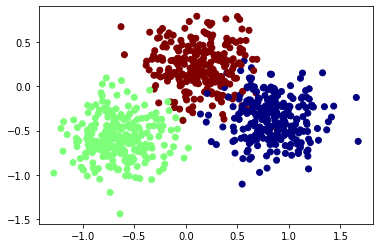

In [ ]:
print("train set")
_ = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="jet")

test set


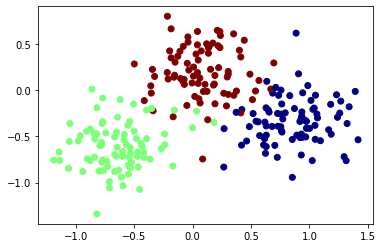

In [ ]:
print("test set")
_ = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="jet")

# Entrenamiento

In [ ]:
def stochastic_gradient_descent(model, X, Y, lr, batch_size, num_classes):
    analytical_weights_grad, analytical_biases_grad = compute_analytical_gradient(model, X, Y, batch_size, num_classes)

    running_loss = 0
    for x, y in zip(X, Y):
        # one hot encode labels
        x = x.reshape(1, -1)
        y = y.reshape(1)
        y_one_hot = one_hot_encode(y, num_classes)

        # feed forward
        y_hat = model.forward(x, grad=True)

        # compute loss and its derivative
        loss = mse(y_hat, y_one_hot)
        d_error = d_mse(y_hat, y_one_hot)
        running_loss += loss

        # backpropagate the error (update gradients)
        model.backward(d_error)

        # gradient descent step
        for i in range(len(model.weights)):
            # update weights
            model.weights[i] += lr * -analytical_weights_grad[i]
            model.biases[i] += lr * -analytical_biases_grad[i]

            # reset gradients
            # model.weights_grad[i].fill(0)
            # model.biases_grad[i].fill(0)

    return running_loss / len(X)

In [ ]:
# NO EJECUTAR
def numerical_gradient_descent(model, X, Y, lr, batch_size, num_classes):
    numerical_weights_grad, numerical_biases_grad = compute_numerical_gradient(
        model, X, Y, batch_size=batch_size, num_classes=num_classes
    )
    for l in range(len(model.weights)):
        model.weights[l] += lr * -numerical_weights_grad[l]
        model.biases[l] += lr * -numerical_biases_grad[l]

    loss = 0
    batches = list(zip(X, Y))
    for i in range(0, len(batches), batch_size):
        batch = batches[i : i + batch_size]
        x, y = zip(*batch)
        x = np.array(x)
        y = np.array(y)
        y_one_hot = one_hot_encode(y, num_classes)
        y_hat = model.forward(x)
        loss += mse(y_hat, y_one_hot) * len(x)
    loss /= len(X)

    return loss

In [ ]:
model = NeuralNetwork(2, [1], 3)

area_map_set = generate_area_map(X_test, points_per_int = 7)
area_map_plot(model, area_map_set, X_test, y_test, alpha = 0.15)

print("Accuracy on Train Set:", np.mean(model.predict(X_train) == y_train))
print("Accuracy on Test Set:", np.mean(model.predict(X_test) == y_test))

In [ ]:
model.weights[0].shape

In [ ]:
model.biases[0].shape

In [ ]:
model.weights[1].shape

In [ ]:
model.biases[1].shape

In [ ]:
loss_history = []
acc_history = []

for epoch in range(100):
    loss = stochastic_gradient_descent(model, X_train, y_train, lr=0.01, batch_size=1 ,num_classes=3)
    acc = np.mean(model.predict(X_test) == y_test)
    loss_history.append(loss)
    acc_history.append(acc)
    if epoch % 10 == 0:
        print(f"epoch: {epoch:<6} loss: {loss:.6f}     accuracy: {acc:.4f}")

# Results

In [ ]:
plt.plot(loss_history)
plt.title("loss")

In [ ]:
plt.plot(acc_history)
plt.title("accuracy")

In [ ]:
area_map_set = generate_area_map(X_test, points_per_int = 7)
area_map_plot(model, area_map_set, X_test, y_test, alpha = 0.15)

print("Accuracy on Train Set:", np.mean(model.predict(X_train) == y_train))
print("Accuracy on Test Set:", np.mean(model.predict(X_test) == y_test))

In [ ]:
model.predict(X_test)

# Ejercicio: Realizar el entrenamiento para nuestros datos de precios de casas, donde se tratará de predecir el precio dadas 5 características (más fácil si son númericas)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
with open('/content/drive/MyDrive/Curso-NN-de-Cero/semana3/data_description.txt') as f:
    lines = f.read()

In [ ]:
print(lines)